In [1]:
### Preamble ###
## Requires use of co-registered DEMs and an ice mask
## Ben Pelto

from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
import salem
from salem import *
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pylab

def cm2inch(*tupl):### plots in cm ##frontiers 180 mm for full width, 85 mm half width (1 column) figures
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
## enable zooming of plots in this notebook
#import mpld3
#mpld3.enable_notebook()
#from mpld3 import plugins

## enable latex symbols in graphs
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]
path_out = '/home/pelto/Desktop/ice_flux/figures/'

def make_gradients(path, path_out, dh_dt, topo, vel, msk, n_min,num,visual=False):
    num=num

    glacier = ['conrad','illecillewaet','kokanee']
    glacier= glacier[num]

    path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier + '/'
        
    NAME = 'vz', 'Z'  #'Depth' 'v'
    bin_size = 100.
   
    vdir=['/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/','/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/',
         '/home/pelto/Desktop/velocity_mapping/kokanee/bedem/3m/']
    vdir=vdir[num]
    if num==0:
        VX = vel[:-5] + 'x.tif' ; VY = vel ;  VM = vel[:-5] + 'm.tif'  
    elif num==1:
        VX = vel ; VY = vel[:-9]+ 'y.tif' ;  VM = vel[:-9]+ 'm.tif'  
    else:
        VX = vel[:-5]+ 'x.tif'; VY = vel ;  VM = vel[:-5]+ 'm.tif'  
        
    msk = salem.open_xr_dataset(path+msk);msk = msk.to_array(name='msk')
#     msk_reproj = vm.salem.transform(msk)
    
    vm = salem.open_xr_dataset(VM);vx = salem.open_xr_dataset(VX);vy = salem.open_xr_dataset(VY)
    vm_reproj=msk.salem.transform(vm)
    vm = vm_reproj.to_array(name='vm');#vx = vx.to_array(name='vx');vy = vy.to_array(name='vy')
    vx_reproj = msk.salem.transform(vx);vy_reproj = msk.salem.transform(vy)
    vx = vx_reproj.to_array(name='vx');vy = vy_reproj.to_array(name='vy')
#     vz=vy.copy(name='vz')
    vz=np.sqrt(vx.data**2 + vy.data**2 )
    dem = salem.open_xr_dataset(path+topo);dem_reproj = msk.salem.transform(dem); dem = dem_reproj.to_array(name='dem')
   
    dh = salem.open_xr_dataset(path+dh_dt); dh_reproj = msk.salem.transform(dh); dh = dh_reproj.to_array(name='dh')
    
    
    vz[msk.data<1.0] = np.nan; dem.data[msk.data<1.0]=np.nan ##remove data off-ice
    vz[vz==0.0]=np.nan; vz[vz<0.1]=np.nan; dem.data[dem.data<1000] = np.nan; vz[vz>55.0]=np.nan;
    

    grid = vm.salem.grid  ##full view
    sm = Map(grid, countries=False)
    sm.set_lonlat_contours(interval=0)
    sm.set_scale_bar()
    sm.set_data(vz)
    if visual==True:
        sm.visualize()
    
    print('Average velocity:', np.round(np.nanmean(vz),2), '+/-',np.round(np.nanstd(vz),2), 'm/yr')
        
    # convert 2-d elevation and SWE arrays to 1-D vectors using ravel function
    Zvec = np.ravel(dem)
#     Depthvec = np.ravel(dh)
    Velvec = np.ravel(vz)
    
    if num ==0:
        if bin_size == 10.:
            bins = range(1800,3400,10)
        else:
            bins = range(1800,3400,100)
    elif num==1:
        bins= range(1900, 2900, 100)
    else:
        bins=range(2200,2800,100)
    
    # create pandas dataframe for elevation and height change
    df = pd.DataFrame({"Z":Zvec, "vz":Velvec}) #"Depth":Depthvec,
  
    # classify the elevation data into 100 metre bins and add to the data frame 
    if num==0:
        if bin_size == 10.:
            df['Zbins'] = pd.cut(df['Z'], bins, labels= np.arange(1805, 3395, 10))
        else:
            df['Zbins'] = pd.cut(df['Z'], bins, labels= np.arange(1850, 3350, 100))
    elif num==1:
        df['Zbins'] = pd.cut(df['Z'], bins, labels= np.arange(1950, 2850, 100))
    else:
        df['Zbins'] = pd.cut(df['Z'], bins, labels= np.arange(2250, 2750, 100))
    # get some statistics from the data # this will be series which can be a pain to work with 
    # so convert to dataframes

    for n in NAME: #'v' 'Depth'
    
        mean = df.groupby(by='Zbins')[n].mean()
        median = df.groupby(by='Zbins')[n].median()
        iqr    = df.groupby(by='Zbins')[n].quantile(0.75) - df.groupby(by='Zbins')[n].quantile(0.25)
        count  = df.groupby(by='Zbins')[n].count()

        ## convert series to pandas data frames instead of series
#         if 
        if n=='Z':
            df_dem= pd.DataFrame(list(zip(mean,iqr,count)), columns=['dem_mean','dem_iqr', 'dem_count'])
#             df_dem.reset_index(inplace=True)
            if num==0:
                df_dem['Zbins'] = np.arange(1850, 3350, 100) 
            elif num==1:
                df_dem['Zbins'] = np.arange(1950, 2850, 100) 
            else:
                df_dem['Zbins'] = np.arange(2250, 2750, 100) 
        else:
            df_vz= pd.DataFrame(list(zip(mean,median, iqr,count)), columns=['vz_mean','vz_median','vz_iqr', 'vz_count'])

    ## returns data frame 
    DF =  pd.concat([df_dem, df_vz], axis=1)
    DF['VZcoverage'] = DF.vz_count / DF.dem_count 
    VZ_list.append(vz)
    return DF, VZ_list

In [ ]:
DF,vz= make_gradients(path, path_out, dh, dem, vel_list[9], extent, n_min,0)

In [ ]:
np.nanmax(vz)

In [ ]:
# Bin_Count=pd.DataFrame()
# for b in np.unique(df.Zbins):
#     if np.isnan(b):
#         continue
#     W= df[df.Zbins==b].vz
#     Counting= np.where(~np.isnan(W))
#     if len(Counting)==0:
#         C=0
#     else:
#         C= len(Counting[0])
#     Bin_Count=Bin_Count.append({'Bin':b,'Count':C},ignore_index=True)

In [60]:
labels_illec

['20170917, 20181016',
 '20170521, 20180426',
 '20170521, 20170917',
 '20160912, 20170917',
 '20160912, 20170521',
 '20160417, 20170521',
 '20150911, 20160912',
 '20150911, 20160417',
 '20150419, 20160417',
 'Mosaic']

In [4]:
# Illecillewaet glacier
n_min = 500. ;    VZ_list=[]
num=1
dh='illecillewaet_2016_winter_dh_dt.tif'
extent='illecillewaet_2014_extent_5m.tif'  #('/home/pelto/Desktop/lidar_cbt_analysis/conrad/conrad_2014_extent_5m.tif'    'conrad_2016_extent_5m.tif'
dem='160912_illecillewaet_dem1_clip_master.tif'
path_out = '/home/pelto/Desktop/ice_flux/figures/'
   
vel_list = ['/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20180426__img2_20181016_vmap_5m_35px_spm2/img1_20180426__img2_20181016_vmap_5m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170917__img2_20181016_vmap_5m_35px_spm2/img1_20170917__img2_20181016_vmap_5m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170521__img1_20180426_vmap_5m_35px_spm2/img1_20170521__img1_20180426_vmap_5m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20170521__img1_20170917_vmap_5m_35px_spm2/img1_20170521__img1_20170917_vmap_5m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20160912__img1_20170917_vmap_5m_35px_spm2/img1_20160912__img1_20170917_vmap_5m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20160912__img1_20170521_vmap_5m_35px_spm2/img1_20160912__img1_20170521_vmap_5m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20160417__img1_20170521_vmap_5m_35px_spm2/img1_20160417__img1_20170521_vmap_5m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150911__img1_20160912_vmap_5.0m_35px_spm2/img1_20150911__img1_20160912_vmap_5.0m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150911__img1_20160417_vmap_5m_35px_spm2/img1_20150911__img1_20160417_vmap_5m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/img1_20150419__img1_20160417_vmap_5m_35px_spm2/img1_20150419__img1_20160417_vmap_5m_35px_spm2-F_vx_neg.tif',
'/home/pelto/Desktop/velocity_mapping/illecillewaet/3m/illecillewaet_all_dem3m_blur1_25m_vx_neg.tif']

ALL_Illec=[]
for i in range(len(vel_list)):
    VEL_Illec,VZ_list_I = make_gradients(path, path_out, dh, dem, vel_list[i], extent, n_min, num, False)
    ALL_Illec.append(VEL_Illec)
    
labels_illec=['20180426, 20181016','20170917, 20181016','20170521, 20180426','20170521, 20170917', '20160912, 20170917',
        '20160912, 20170521','20160417, 20170521','20150911, 20160912', '20150911, 20160417',
        '20150419, 20160417','Mosaic']
 

Average velocity: 8.71 +/- 8.43 m/yr
Average velocity: 9.0 +/- 8.63 m/yr
Average velocity: 12.18 +/- 9.93 m/yr
Average velocity: 14.97 +/- 10.33 m/yr
Average velocity: 15.72 +/- 10.91 m/yr
Average velocity: 19.06 +/- 11.65 m/yr
Average velocity: 18.45 +/- 11.62 m/yr
Average velocity: 18.35 +/- 11.07 m/yr
Average velocity: 16.8 +/- 10.46 m/yr
Average velocity: 15.95 +/- 9.86 m/yr
Average velocity: 14.79 +/- 8.53 m/yr


In [7]:
num

1

Average velocity: 14.79 +/- 8.53 m/yr


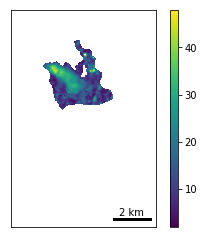

In [9]:
# Illecillewaet glacier
n_min = 500. ;    VZ_list=[]
num=1
dh='illecillewaet_2016_winter_dh_dt.tif'
extent='illecillewaet_2014_extent_5m.tif'  #('/home/pelto/Desktop/lidar_cbt_analysis/conrad/conrad_2014_extent_5m.tif'    'conrad_2016_extent_5m.tif'
dem='160912_illecillewaet_dem1_clip_master.tif'
path_out = '/home/pelto/Desktop/ice_flux/figures/'

DF,vz= make_gradients(path, path_out, dh, dem, vel_list[10], extent, n_min,1,True)

In [181]:
d=VZ_list_I[3]-VZ_list_I[4]
dp=(VZ_list_I[3]-VZ_list_I[4])/VZ_list_I[4]
illec_slide=np.nanmedian(d)
illec_slidep=np.nanmean(dp)
print(illec_slide)#, con_slidep)
print('% sliding:', round(illec_slide/15.72*100,2))

-0.44085932
% sliding: -2.8


In [59]:
cover=[]
for i in range(len(ALL_Illecllec)):
    cover.append(ALL_Illec[i].vz_count.sum()/ALL_Illec[i].dem_count.sum())
cover

[0.9150549596681338,
 0.8770324049598303,
 0.9089962603424397,
 0.8994962976417129,
 0.8713207510451905,
 0.8796076765147559,
 0.7527771741421978,
 0.7443280779198033,
 0.7790682965908464,
 0.7194964922466163,
 0.988641560471852]

In [ ]:
DF,vz_list= make_gradients(path, path_out, dh, dem, vel_list[4], extent, n_min,1,True)

In [25]:
for i in range(len(VZ_list_I)):
    print(i, np.shape(VZ_list_I[i]))

0 (1, 2402, 1602)
1 (1, 2402, 1602)
2 (1, 2402, 1602)
3 (1, 2402, 1602)
4 (1, 2402, 1602)
5 (1, 2402, 1602)
6 (1, 2402, 1602)
7 (1, 2402, 1602)
8 (1, 2402, 1602)
9 (1, 2402, 1602)
10 (1, 2402, 1602)


In [26]:
interA_d=[];interA_p=[]
for i in range(len(VZ_list_I)):
    A=VZ_list_I[10]-VZ_list_I[i]
    interA_d.append(np.nanmedian(A))
    B=A/VZ_list_I[10]
    interA_p.append(np.nanmedian(B))
    
interA_p, interA_d,np.median(interA_d[:-1]), np.median(interA_p[:-1])

([0.48231468,
  0.45945415,
  0.16477242,
  0.0071904548,
  -0.01929637,
  -0.15345766,
  -0.08281656,
  -0.06593678,
  -0.09429911,
  -0.011556881,
  0.0],
 [6.3074265,
  5.1139956,
  2.0585842,
  0.09517717,
  -0.2790594,
  -2.7084103,
  -1.3795929,
  -1.035738,
  -1.5597324,
  -0.17167377,
  0.0],
 -0.22536659,
 -0.0154266255)

In [ ]:
VZ_list[10]

In [10]:
# Kokanee Glacier
n_min = 500. ;    VZ_list=[]
num=2
dh='kokanee_2016_2015_dh_dt.tif'
extent='kokanee_2015_extent_5m.tif' 
dem='20150912_kokanee_ppp_dem1_clip.tif'
   
# vel_list = [#'/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20150419__img2_20150912_vmap_5m_35px_spm2/img1_20150419__img2_20150912_vmap_5m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20150419__img2_20160417_vmap_5m_35px_spm2/img1_20150419__img2_20160417_vmap_5m_35px_spm2-F_vy.tif',
# # '/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20150912__img2_20160417_vmap_5m_35px_spm2/img1_20150912__img2_20160417_vmap_5m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20150912__img2_20160913_vmap_5m_35px_spm2/img1_20150912__img2_20160913_vmap_5m_35px_spm2-F_vy.tif',
# # '/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20160417__img2_20160913_vmap_5m_35px_spm2/img1_20160417__img2_20160913_vmap_5m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20160417__img2_20170521_vmap_5m_35px_spm2/img1_20160417__img2_20170521_vmap_5m_35px_spm2-F_vy.tif',
# # '/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20160913__img2_20170521_vmap_5m_35px_spm2/img1_20160913__img2_20170521_vmap_5m_35px_spm2-F_vy.tif',
# # '/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20160913__img2_20170916_vmap_5m_35px_spm2/img1_20160913__img2_20170916_vmap_5m_35px_spm2-F_vy.tif',
# # '/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20170521__img2_20180426_vmap_5m_35px_spm2/img1_20170521__img2_20180426_vmap_5m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/kokanee/dem/kokanee_all_dem1m_5m_vy.tif']

vel_list = ['/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20150419__img2_20150912_vmap_5m_35px_spm2/img1_20150419__img2_20150912_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20150419__img2_20160417_vmap_5m_35px_spm2/img1_20150419__img2_20160417_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20150912__img2_20160417_vmap_5m_35px_spm2/img1_20150912__img2_20160417_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20150912__img2_20160913_vmap_5m_35px_spm2/img1_20150912__img2_20160913_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20160417__img2_20160913_vmap_5m_35px_spm2/img1_20160417__img2_20160913_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20160417__img2_20170521_vmap_5m_35px_spm2/img1_20160417__img2_20170521_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20160913__img2_20170521_vmap_5m_35px_spm2/img1_20160913__img2_20170521_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20160913__img2_20170916_vmap_5m_35px_spm2/img1_20160913__img2_20170916_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/kokanee/dem/img1_20170521__img2_20180426_vmap_5m_35px_spm2/img1_20170521__img2_20180426_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/kokanee/dem/kokanee_all_dem1m_5m_vy.tif']

ALL_kok=[]
for i in range(len(vel_list)):
    VEL_kok,VZ_list_K = make_gradients(path, path_out, dh, dem, vel_list[i], extent, n_min, num, False)
    ALL_kok.append(VEL_kok)
    
labels_kok=['20150419, 20150912','20150419, 20160417','20150912, 20160417', '20150912, 20160913',
        '20160417, 20160913','20160417, 20170521','20160913, 20170521', '20160913, 20170916',
        '20170521, 20180426','Mosaic']
 

Average velocity: 10.91 +/- 8.87 m/yr
Average velocity: 3.38 +/- 4.12 m/yr
Average velocity: 7.07 +/- 5.93 m/yr
Average velocity: 1.83 +/- 2.5 m/yr
Average velocity: 7.84 +/- 6.11 m/yr
Average velocity: 4.28 +/- 3.94 m/yr
Average velocity: 8.62 +/- 6.49 m/yr
Average velocity: 2.29 +/- 3.69 m/yr
Average velocity: 9.93 +/- 10.97 m/yr
Average velocity: 6.7 +/- 6.26 m/yr


Average velocity: 2.29 +/- 3.69 m/yr


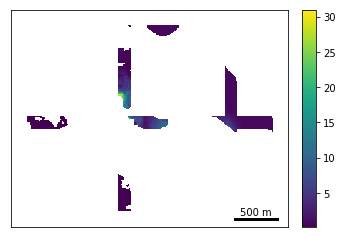

In [24]:
DF,vz= make_gradients(path, path_out, dh, dem, vel_list[7], extent, 50,2,True)

In [178]:
d=VZ_list_K[0]-VZ_list_K[1]
dp=(VZ_list_K[0]-VZ_list_K[1])/VZ_list_K[1]
kok_slide=np.nanmedian(d)
kok_slidep=np.nanmean(dp)
print(kok_slide)#, con_slidep)
print('% sliding:', round(kok_slide/6.7*100,2))

5.8849726
% sliding: 87.84


In [47]:
interA_d=[];interA_p=[]
for i in range(len(VZ_list_K)):
    A=VZ_list_K[9]-VZ_list_K[i]
    interA_d.append(np.nanmedian(A))
    B=A/VZ_list_K[9]
    interA_p.append(np.nanmedian(B))
    
interA_p, interA_d,np.median(interA_d[:-1]), np.median(interA_p[:-1])
# kp=np.abs(interA_p)
# kd=np.abs(interA_d)
# np.median(kd), np.median(kp)

([-0.8135488,
  0.4894089,
  -0.19632557,
  0.80251855,
  -0.3313286,
  0.21342385,
  -0.51898944,
  0.87101394,
  -0.36723867,
  0.0],
 [-3.1380033,
  1.9940783,
  -0.6894572,
  3.3391974,
  -1.245569,
  0.7690337,
  -2.2018032,
  4.0492296,
  -1.1140479,
  0.0],
 -0.6894572,
 -0.19632557)

In [57]:
cover=[]
for i in range(len(ALL_kok)):
    cover.append(ALL_kok[i].vz_count.sum()/ALL_kok[i].dem_count.sum())
cover

[0.5500432536249712,
 0.5964714565757414,
 0.5958682867596289,
 0.5808882469186752,
 0.620324441869509,
 0.7345457575733526,
 0.7399187308037238,
 0.08366203442829818,
 0.6786771533559257,
 0.8092594503218229]

In [6]:
# conrad glacier
n_min = 500. ;num=0; VZ_list=[]

dh='conrad_2015_2016_dh_dt_filled_17_5m.tif'
extent='conrad_2014_extent_5m.tif'  #('/home/pelto/Desktop/lidar_cbt_analysis/conrad/conrad_2014_extent_5m.tif'    'conrad_2016_extent_5m.tif'
dem='20160912_conrad_dem1_clip_slave_5m.tif'

###### vy_all  #######################
vel_list = ['/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20170521__img2_20180426_vmap_5.0m_35px_spm2/img1_20170521__img2_20180426_vmap_5.0m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160912__img2_20170917_vmap_5m_35px_spm2/img1_20160912__img2_20170917_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160912__img1_20170521_vmap_5.0m_35px_spm2/img1_20160912__img1_20170521_vmap_5.0m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/img1_20160417__img1_20170521_vmap_5.0m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160417__img1_20160912_vmap_5.0m_35px_spm2/img1_20160417__img1_20160912_vmap_5.0m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20150912__img1_20160912_vmap_5.0m_35px_spm2/img1_20150912__img1_20160912_vmap_5.0m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20150912__img1_20160417_vmap_5.0m_35px_spm2/img1_20150912__img1_20160417_vmap_5.0m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20150420__img1_20160417_vmap_5.0m_35px_spm2/img1_20150420__img1_20160417_vmap_5.0m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20160830__img1_20170809_vmap_5m_35px_spm2/img1_20160830__img1_20170809_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20160830__img1_20170904_vmap_5m_35px_spm2/img1_20160830__img1_20170904_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20170904__img2_20180822_vmap_5m_35px_spm2/img1_20170904__img2_20180822_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/conrad_planet/img2_20170927__img2_20180822_vmap_5m_35px_spm2/img2_20170927__img2_20180822_vmap_5m_35px_spm2-F_vy.tif',
'/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/conrad_all_3mdems+planet_25m_vy.tif'          ] 
########### conrad best ##################
# vel_list = ['/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20170521__img2_20180426_vmap_5.0m_35px_spm2/img1_20170521__img2_20180426_vmap_5.0m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160912__img2_20170917_vmap_5m_35px_spm2/img1_20160912__img2_20170917_vmap_5m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/img1_20160417__img1_20170521_vmap_5.0m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20150912__img1_20160912_vmap_5.0m_35px_spm2/img1_20150912__img1_20160912_vmap_5.0m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/img1_20150420__img1_20160417_vmap_5.0m_35px_spm2/img1_20150420__img1_20160417_vmap_5.0m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20160830__img1_20170809_vmap_5m_35px_spm2/img1_20160830__img1_20170809_vmap_5m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20160830__img1_20170904_vmap_5m_35px_spm2/img1_20160830__img1_20170904_vmap_5m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/conrad_planet/img1_20170904__img2_20180822_vmap_5m_35px_spm2/img1_20170904__img2_20180822_vmap_5m_35px_spm2-F_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/conrad_planet/img2_20170927__img2_20180822_vmap_5m_35px_spm2/img2_20170927__img2_20180822_vmap_5m_35px_spm2-F_vy.tif',
# # '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/conrad_all_3mdems+planet_5m_vy.tif',
# '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/conrad_all_3mdems+planet_25m_vy.tif'] 
       
#     'img1_20150420__img1_20160417_vmap_5.0m_35px_spm2/img1_20150420__img1_20160417_vmap_5.0m_35px_spm2-F_vm.tif', 
# #             'img1_20150912__img1_20160417_vmap_5.0m_35px_spm2/img1_20150912__img1_20160417_vmap_5.0m_35px_spm2-F_vm.tif', 
#             'img1_20150912__img1_20160912_vmap_5.0m_35px_spm2/img1_20150912__img1_20160912_vmap_5.0m_35px_spm2-F_vm.tif',
#             'img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/img1_20160417__img1_20170521_vmap_5.0m_35px_spm2-F_vm.tif',
# #             'img1_20160912__img1_20170521_vmap_5.0m_35px_spm2/img1_20160912__img1_20170521_vmap_5.0m_35px_spm2-F_vm.tif',
#             'img1_20160912__img2_20170917_vmap_5m_35px_spm2/img1_20160912__img2_20170917_vmap_5m_35px_spm2-F_vm.tif',
#             'img1_20170521__img2_20180426_vmap_5.0m_35px_spm2/img1_20170521__img2_20180426_vmap_5.0m_35px_spm2-F_vm.tif',
# #             'img1_20160830__img1_20170904_vmap_5m_35px_spm2/img1_20160830__img1_20170904_vmap_5m_35px_spm2-F_vm.tif',
# #             'img1_20160830__img1_20170809_vmap_5m_35px_spm2/img1_20160830__img1_20170809_vmap_5m_35px_spm2-F_vm.tif',
# #             'img1_20140911__img1_20150420_vmap_5.0m_35px_spm2/img1_20140911__img1_20150420_vmap_5.0m_35px_spm2-F_vm.tif',
# #             'img1_20150915__img2_20160417_vmap_5.0m_35px_spm2/img1_20150915__img2_20160417_vmap_5.0m_35px_spm2-F_vm.tif',
#             'img1_20150420__img1_20150912_vmap_5.0m_35px_spm2/img1_20150420__img1_20150912_vmap_5.0m_35px_spm2-F_vm.tif',
#             'img1_20160417__img1_20160912_vmap_5.0m_35px_spm2/img1_20160417__img1_20160912_vmap_5.0m_35px_spm2-F_vm.tif',
#             'img1_20170521__img2_20170917_vmap_5.0m_35px_spm2/img1_20170521__img2_20170917_vmap_5.0m_35px_spm2-F_vm.tif',
# #             'conrad_all_vm_3mdems+planet_5m.tif']
#            ]
ALL=[]
for i in range(len(vel_list)):
    VEL,VZ_list_C = make_gradients(path, path_out, dh, dem, vel_list[i], extent, n_min,num, False)
    ALL.append(VEL)
    
# labels=['20170521, 20180426','20160912, 20170917','20160417, 20170521', '20150912, 20160912','20150420, 20160417',
#         '20160830, 20170809','20160830, 20170904', '20170904, 20180822','20170927, 20180822','Mosaic']
    
labels_con=['20170521, 20180426','20160912, 20170917','20160912, 20170521','20160417, 20170521','20160417, 20160912',
        '20150912, 20160912','20150912, 20160417','20150420, 20160417','20160830, 20170809','20160830, 20170904',
        '20170904, 20180822','20170927, 20180822','Mosaic']
    
        
#     'img1_20150420__img1_20160417',
# #        'img1_20150912__img1_20160417',
#        'img1_20150912__img1_20160912',
#        'img1_20160417__img1_20170521',
# #        'img1_20160912__img1_20170521',
#        'img1_20160912__img2_20170917',
#        'img1_20170521__img2_20180426',
# #        'img1_20160830__img1_20170904',
# #        'img1_20160830__img1_20170809',
# #         'img1_20140911__img1_20150420',
# #         'img1_20150915__img2_20160417',
#         'img1_20150420__img1_20150912',
#         'img1_20160417__img1_20160912',
#         'img1_20170521__img2_20170917',
# #        'conrad_all_vm_3mdems+planet5m']

Average velocity: 16.32 +/- 12.77 m/yr
Average velocity: 15.58 +/- 11.73 m/yr
Average velocity: 23.09 +/- 13.47 m/yr
Average velocity: 17.23 +/- 12.6 m/yr
Average velocity: 19.49 +/- 11.61 m/yr
Average velocity: 17.49 +/- 12.51 m/yr
Average velocity: 25.37 +/- 14.19 m/yr
Average velocity: 15.75 +/- 11.93 m/yr
Average velocity: 18.87 +/- 12.08 m/yr
Average velocity: 18.74 +/- 11.94 m/yr
Average velocity: 17.94 +/- 11.86 m/yr
Average velocity: 18.86 +/- 13.22 m/yr
Average velocity: 17.0 +/- 12.2 m/yr


In [32]:
# VZ_list_C=VZ_list_C[:-10]
len(VZ_list_C)

13

In [153]:
labels_con

['20170521, 20180426',
 '20160912, 20170917',
 '20160912, 20170521',
 '20160417, 20170521',
 '20160417, 20160912',
 '20150912, 20160912',
 '20150912, 20160417',
 '20150420, 20160417',
 '20160830, 20170809',
 '20160830, 20170904',
 '20170904, 20180822',
 '20170927, 20180822',
 'Mosaic']

In [171]:
d=VZ_list_C[4]-VZ_list_C[1]
dp=(VZ_list_C[4]-VZ_list_C[1])/VZ_list_C[1]
con_slide=np.nanmedian(d)
con_slidep=np.nanmean(dp)
print(con_slide)#, con_slidep)
print('% sliding:', round(con_slide/19.45*100,2))

2.5285597
% sliding: 13.0


0.1488235294117647

In [33]:
for i in range(len(VZ_list_C)):
    print(i, np.shape(VZ_list_C[i]))

0 (1, 2402, 3842)
1 (1, 2402, 3842)
2 (1, 2402, 3842)
3 (1, 2402, 3842)
4 (1, 2402, 3842)
5 (1, 2402, 3842)
6 (1, 2402, 3842)
7 (1, 2402, 3842)
8 (1, 2402, 3842)
9 (1, 2402, 3842)
10 (1, 2402, 3842)
11 (1, 2402, 3842)
12 (1, 2402, 3842)


In [34]:
interA_d_c=[];interA_p_c=[]
for i in range(len(VZ_list_C)):
    A=VZ_list_C[9]-VZ_list_C[i]
    interA_d_c.append(np.nanmedian(A))
    B=A/VZ_list_C[9]
    interA_p_c.append(np.nanmedian(B))
    
interA_p_c, interA_d_c,np.median(interA_d_c[:-1]), np.median(interA_p_c[:-1])

([0.06564596,
  0.062327974,
  -0.3332008,
  -0.029019574,
  -0.06824586,
  0.033823248,
  -0.33996028,
  0.03207636,
  -0.110582314,
  0.0,
  0.004880972,
  -0.04997131,
  0.03709741704119539],
 [0.6939088,
  0.7051152,
  -4.970316,
  -0.36447746,
  -1.1203156,
  0.50315624,
  -5.47428,
  0.37482592,
  -1.776505,
  0.0,
  0.087944925,
  -0.65685225,
  0.5371159823589373],
 -0.18223873,
 -0.014509787)

In [40]:
cover=[]
for i in range(len(ALL)):
    cover.append(ALL[i].vz_count.sum()/ALL[i].dem_count.sum())
cover

[0.8897942501347896,
 0.6530949440840391,
 0.9010078786719307,
 0.8801328764979043,
 0.9246351983581752,
 0.7551741830008523,
 0.6986516687827191,
 0.8482703445397152,
 0.5466154755900308,
 0.8379958954380229,
 0.8196623302085326,
 0.6089382924326486,
 0.9723681235542724]

In [ ]:
for i in range(len(ALL)):
    print(ALL[i].vz_mean.max())

In [75]:
    
labels_con=['20170521, 20180426','20160912, 20170917','20160912, 20170521','20160417, 20170521','20160417, 20160912',
        '20150912, 20160912','20150912, 20160417','20150420, 20160417','20160830, 20170809','20160830, 20170904',
        '20170904, 20180822','20170927, 20180822','Mosaic']
    

In [86]:
palette = sns.cubehelix_palette(13, start=.5, rot=-.75)


In [90]:
len(labels[p])

13

In [98]:
len(ALL_kok)

10

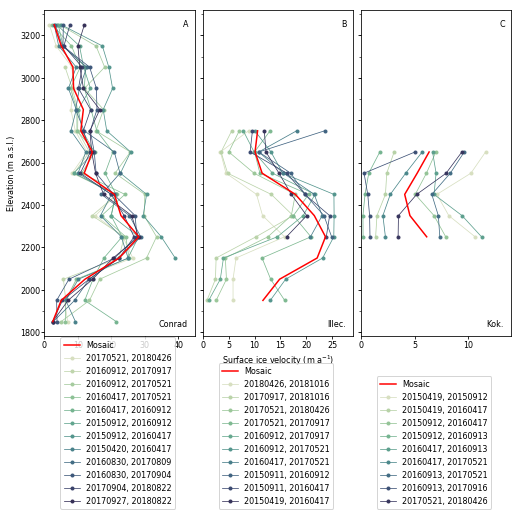

In [49]:
ALL_3=[ALL,ALL_Illec,ALL_kok]
labels=[labels_con,labels_illec,labels_kok]

font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.'
pylab.rcParams['ytick.major.pad']='1.'

letter= ['A', 'B', 'C']
glac = ['Conrad', 'Illec.', 'Kok.']
## Code below is a hack. It should be written as a set of functions
## when one has more time (interate over objects and names)
bin_size = 100
#glacier = 'zillmer'
## write dataframes to output
# for year in years:
#     year.to_csv(path_out + glacier + 'D_' + year + '.csv')
# c_2015.to_csv(path_out + glacier + NAME + str(bin_size) + '_2015.csv')
# c_2016.to_csv(path_out + glacier + NAME + str(bin_size) + '_2016.csv')
# c_2017.to_csv(path_out + glacier + NAME + str(bin_size) + '_2017.csv')
# c_2018.to_csv(path_out + glacier + NAME + str(bin_size) + '_2018.csv')

## make a few plots
## since function 'make_snow_gradients' returns pandas series with indexes 
## we have to extract values noted in cALL_3[p]s to objects in plot values
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
# palette = sns.cubehelix_palette(13, start=.5, rot=-.75)
palette1 = sns.cubehelix_palette(6)

plt.rcParams['figure.figsize'] = (cm2inch(18,18))

fig, ax = plt.subplots(1,3, sharey=True)
for p in range(3):
    palette = sns.cubehelix_palette(len(labels[p]), start=.5, rot=-.75)
    ax[p].plot(ALL_3[p][-1].vz_median, ALL_3[p][-1].Zbins, c='r', lw=1.5, label=labels[p][-1], zorder=1)
    for i in range(len(ALL_3[p])-1):
    #     sns.scatterplot(x="v", y="Zbins", palette=palette, legend="full", markers='--o',data=ALL_3[p][i], ax=ax)
    #     if i < 7:  
        ax[p].plot(ALL_3[p][i].vz_median, ALL_3[p][i].Zbins, c=palette[i], marker='o', ms=3,lw=0.75, label=labels[p][i], zorder=0)
    #     else: #if i > 4:
    #         ax.plot(ALL_3[p][i][NAME], ALL_3[p][i]['Zbins'], c=palette1[i-7], marker='o', label=labels[i])
    # ax.plot(ALL_3[p][-2]['vz_median'], ALL_3[p][i]['Zbins'], c='#de2d26', marker='', ms=5, label=labels[-2],lw=2.5,ls='--')
#     ax[p].plot(ALL_3[p][i].vz_median, ALL_3[p][i]['Zbins'], c='k', marker='', ms=5, label=labels[p],lw=2.5,ls='--')
    # ax.plot(c_2016[NAME], c_2016['Zbins'], c='#dfc27d', marker='*', label='2016')
    # ax.plot(c_2017[NAME], c_2017['Zbins'], c='#80cdc1', marker='.', label='2017')
    # ax.plot(c_2018[NAME], c_2018['Zbins'], c='#018571', marker='^', label='2018')
    # ax.plot(c_2019[NAME], c_2019['Zbins'], c='#018571', marker='^', label='2019')
    # ax.plot(c_2020[NAME], c_2020['Zbins'], c='#018571', marker='^', label='2020')
    # ax.plot(c_2021[NAME], c_2021['Zbins'], c='#018571', marker='^', label='2021')
    # ax.plot(c_2022[NAME], c_2022['Zbins'], c='#018571', marker='^', label='2022')
    # ax.plot(c_2023[NAME], c_2023['Zbins'], c='#018571', marker='^', label='2023')
    ax[0].set_ylabel('Elevation (m a.s.l.)')

    ## These limits are scaled to fit ALL_3[p] data 
    ## to keep scaling consistent. These can be cahnged
#     if NAME == 'Depth':
#         ax[p].set_xlim([-10, 4])
#         ax[p].set_xlabel('Height Change [m]')
#     else: 
    ax[0].set_xlim([0, 45]);ax[1].set_xlim([0, 29]);ax[2].set_xlim([0, 14]);ax[2].set_xticks(np.arange(0, 15,5))
    
    ax[1].set_xlabel('Surface ice velocity (m a$^{-1}$)')
#     ax[p].set_ylim([1800, 3325])

    # Make a plot with major ticks that are multiples of 20 and minor ticks that
    # are multiples of 5.  Label major ticks with '%d' formatting but don't label
    # minor ticks.
    ax[p].yaxis.set_major_locator(MultipleLocator(200))
    ax[p].yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax[p].tick_params(which='major', length=3)
    ax[p].text(0.92, 0.95, letter[p], fontweight='normal', transform=ax[p].transAxes)
    ax[p].text(0.95, 0.03, glac[p], fontweight='normal', transform=ax[p].transAxes,horizontalalignment='right')
    # For the minor ticks, use no labels; default NullFormatter.
    ax[2].yaxis.set_minor_locator(MultipleLocator(100))
#     ax[p].grid(color='grey', alpha=0.6,linestyle="--")
    ax[p].legend(loc='lower left', bbox_to_anchor=(0.08, -0.54))
# plt.tight_layout()

# if NAME == 'Depth':
#     plt.savefig(path_out + glacier + '_height_change_on_ice.pdf', resolution=600)
# else:
fig.subplots_adjust(bottom=0.35, top=0.99, hspace=0.1, left=0.075, right=0.99, wspace=0.05)
plt.savefig(path_out + 'Conrad_Illec_Kok_ice_velocity_new.pdf', resolution=300)
plt.show()

In [2]:
# conrad example:
ub=(62-53)/3.154e7;phi=11.; h=130.; 
# Illec. example:
ub=(62-53)/3.154e7;phi=11.; h=130.; 

In [3]:
rho_i=910.;g=9.81; A=3.24e-24; n=3

Tb=rho_i*g*h*np.deg2rad(phi)
Tb

222804.42134634368

In [4]:
q=(ub*h)+(((2*A)/(n+2)) * (Tb**n) * h**(2))
Ud=q/h
Ud

2.1488106178444808e-06

In [5]:
Us=ub+(((2*A)/(n+1))*(Tb**n)*h)
Us

2.6146752887926016e-06

In [6]:
print('surface vel. m yr:', Us*3.154e7)

surface vel. m yr: 82.46685860851865


In [7]:
print('ratio of Ud to Us:', Ud/Us)

ratio of Ud to Us: 0.8218269500059999


In [ ]:
ALL_3[p][i][5]

In [ ]:
ALL_3[0][0]

In [ ]:
ALL_3[p][i]['vz_median']

In [ ]:
ax[p].plot(ALL_3[p][i]['vz_median'], ALL_3[p][i]['Zbins'], c=palette[i], marker='o', ms=5, label=labels[p][i])

In [ ]:
total_area=ALL[0].dem_count.sum()
Medians=[]
VAR=[]
sum_vz_count=[]

for z in range(len(ALL[i])):
    A=[];
    for i in range(len(ALL)):
        A.append(ALL[i].vz_median[z])
      
    STD=np.nanstd(A)
    var=np.var(A)
    mean_vz_count.append(mvz)
    Medians.append(STD)
    VAR.append(var)

In [ ]:
total_area=ALL[0].dem_count.sum()
mean_vz_count=[]
for i in range(len(ALL)):
    mean_vz_count.append(ALL[i].vz_count.sum())
print(np.mean(mean_vz_count)/total_area)
print(np.min(mean_vz_count)/total_area)
print(np.max(mean_vz_count)/total_area)

In [ ]:

# ## Code below is a hack. It should be written as a set of functions
# ## when one has more time (interate over objects and names)
# bin_size = 100
# #glacier = 'zillmer'
# ## write dataframes to output
# # for year in years:
# #     year.to_csv(path_out + glacier + 'D_' + year + '.csv')
# # c_2015.to_csv(path_out + glacier + NAME + str(bin_size) + '_2015.csv')
# # c_2016.to_csv(path_out + glacier + NAME + str(bin_size) + '_2016.csv')
# # c_2017.to_csv(path_out + glacier + NAME + str(bin_size) + '_2017.csv')
# # c_2018.to_csv(path_out + glacier + NAME + str(bin_size) + '_2018.csv')


# ## make a few plots
# ## since function 'make_snow_gradients' returns pandas series with indexes 
# ## we have to extract values noted in calls to objects in plot values
# from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
#                                AutoMinorLocator)

# plt.rcParams['figure.figsize'] = 5, 10

# fig, ax = plt.subplots()


# ax.plot(c_2015[NAME], c_2015['Zbins'], c='#a6611a', marker='o', label='2015')
# ax.plot(c_2016[NAME], c_2016['Zbins'], c='#dfc27d', marker='*', label='2016')
# ax.plot(c_2017[NAME], c_2017['Zbins'], c='#80cdc1', marker='.', label='2017')
# ax.plot(c_2018[NAME], c_2018['Zbins'], c='#018571', marker='^', label='2018')

# ax.set_ylabel('Elevation [m asl]')


# ## These limits are scaled to fit all data 
# ## to keep scaling consistent. These can be cahnged
# if NAME == 'Depth':
#     ax.set_xlim([-10, 4])
#     ax.set_xlabel('Height Change [m]')
# else: 
#     ax.set_xlim([0, 30])
#     ax.set_xlabel('Ice Velocity [m]')
# ax.set_ylim([1450, 3400])

# # Make a plot with major ticks that are multiples of 20 and minor ticks that
# # are multiples of 5.  Label major ticks with '%d' formatting but don't label
# # minor ticks.
# ax.yaxis.set_major_locator(MultipleLocator(200))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))

# # For the minor ticks, use no labels; default NullFormatter.
# ax.yaxis.set_minor_locator(MultipleLocator(50))
# plt.grid(color='grey')

# plt.tight_layout()
# plt.legend()
# if NAME == 'Depth':
#     plt.savefig(path_out + glacier + '_height_change_on_ice.pdf', resolution=600)
# else:
#     plt.savefig(path_out + glacier + '_ice_velocity.pdf', resolution=600)
# plt.show()

In [ ]:

# for NAME in ['Depth','v']:
#     median = df.groupby(by='Zbins')[NAME].median()
#     iqr   = df.groupby(by='Zbins')[NAME].quantile(0.75) - df.groupby(by='Zbins')[NAME].quantile(0.25)
#     count  = df.groupby(by='Zbins')[NAME].count()

#     ## remove any values that are less than 100 values
#     ## these are series not pandas dataframes

#     ## convert series to pandas data frames instead of series

#     median = median.to_frame() 
#     iqr    = iqr.to_frame()
#     count  = count.to_frame()

#     OUT= pd.DataFrame({'D':np.array(median),'iqr': np.array(iqr),'count' : np.array(count),
#              'Zbins':np.array(df.Zbins)})

In [ ]:
# ## Call function to make dataframes for plotting

# ## this sets the minimum count of a given elevation bin

# n_min = 500. 

# c_2015 = make_snow_gradients(path, path_out, 'conrad_bedem_master_5m.tif', 
#                     'conrad_2015_winter_5m.tif', 
#                     'conrad_2016_ice_msk_5m.tif', n_min)

# c_2016 = make_snow_gradients(path, path_out, 'conrad_bedem_master_5m.tif', 
#                     'conrad_2016_winter_5m.tif', 
#                     'conrad_2016_ice_msk_5m.tif', n_min)

# c_2017 = make_snow_gradients(path, path_out, 'conrad_bedem_master_5m.tif', 
#                     'conrad_2017_winter_5m.tif', 
#                     'conrad_2016_ice_msk_5m.tif', n_min)

# c_2018 = make_snow_gradients(path, path_out, 'conrad_bedem_master_5m.tif', 
#                     'conrad_2018_winter_5m.tif', 
#                     'conrad_2016_ice_msk_5m.tif', n_min)


In [ ]:

## Code below is a hack. It should be written as a set of functions
## when one has more time (interate over objects and names)

## write dataframes to output
c_2015.to_csv(path_out + 'conrad_2015.csv')
c_2016.to_csv(path_out + 'conrad_2016.csv')
c_2017.to_csv(path_out + 'conrad_2017.csv')
c_2018.to_csv(path_out + 'conrad_2018.csv')


## make a few plots
## since function 'make_snow_gradients' returns pandas series with indexes 
## we have to extract values noted in calls to objects in plot values
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.rcParams['figure.figsize'] = 5, 10

fig, ax = plt.subplots()


ax.plot(c_2015['Depth'], c_2015['Zbins'],'-ro', label='2015')
ax.plot(c_2016['Depth'], c_2016['Zbins'], '-g*', label='2016')
ax.plot(c_2017['Depth'], c_2017['Zbins'], '-k.', label='2017')
ax.plot(c_2018['Depth'], c_2018['Zbins'], '-b^', label='2018')
ax.set_ylabel('Elevation [m asl]')
ax.set_xlabel('Snow depth [m]')

## These limits are scaled to fit all data 
## to keep scaling consistent. These can be cahnged
ax.set_xlim([0, 5])
ax.set_ylim([1100, 3250])

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(50))
plt.grid(color='grey')

plt.tight_layout()
plt.legend()
plt.savefig(path_out + 'Conrad_snow_gradients_off_ice.pdf', resolution=600)
plt.show()

In [ ]:
## try kokanee
path = '/Volumes/Powermac_backup/lidar_cbt_analysis/kokanee/'
k_2018 = make_snow_gradients(path, path_out, '160913_Kokanee_bedem_5m.tif', 
                    '180426_kokanee_winter_5m.tif', 
                    'kokanee_2016_ice_msk_5m.tif')

In [ ]:
## make a few plots
plt.rcParams['figure.figsize'] = 5, 10
#plt.plot(c_2015.get_values(), c_2015.index.get_values(),'-ro', label='2015')
#plt.plot(c_2016.get_values(), c_2016.index.get_values(), '-g*', label='2016')
#plt.plot(c_2017.get_values(), c_2017.index.get_values(), '-k.', label='2017')
plt.plot(k_2018.get_values(), k_2018.index.get_values(), '-b^', label='2018')
plt.ylabel('Elevation [m asl]')
plt.xlabel('Snow depth [m]')
plt.tight_layout()
plt.legend()
plt.savefig('Kokanee_snow_gradients_off_ice.pdf', resolution=600)
plt.show()

In [ ]:

glacier = 'conrad'

path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier + '/'
path_out = '/home/pelto/Desktop/ice_flux/figures/'

## this will be done for many sites to make a function call to extract
## data of interest 
## uses panda  

NAME = 'vz', 'Z'  #'Depth' 'v'
bin_size = 100.
n_min = 500. 

dh_dt='conrad_2015_2016_dh_dt_filled_17_5m.tif'
msk='conrad_2014_extent_5m.tif'  #('/home/pelto/Desktop/lidar_cbt_analysis/conrad/conrad_2014_extent_5m.tif'    'conrad_2016_extent_5m.tif'
topo='20160912_conrad_dem1_clip_slave_5m.tif'

# def make_gradients(path, path_out, dh_dt, topo, vel, msk, n_min):
    # open GeoTIFF as array
#     dh_dt = gdal.Open(path + dh_dt).ReadAsArray()
#     dem   = gdal.Open(path + dem).ReadAsArray()

#     msk   = gdal.Open(path + msk).ReadAsArray() 
#     vel   = gdal.Open('/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/'+ vel).ReadAsArray() #/vm/ 
# for i in range(len(vel_list)):
#     vel=vel_list[i]
vel=vel_list[1]
vdir='/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/'
VX = vel[:-5] + 'x.tif'  #vdir + vel[:-5] + 'x.tif' 
VY = vel                 #vdir + vel[:-5] + 'y.tif' 
VM = vel[:-5] + 'm.tif' #vdir + vel[:-5] + 'm.tif' 

vm = salem.open_xr_dataset(VM);vx = salem.open_xr_dataset(VX);vy = salem.open_xr_dataset(VY)
vm = vm.to_array(name='vm');#vx = vx.to_array(name='vx');vy = vy.to_array(name='vy')
vx_reproj = vm.salem.transform(vx);vy_reproj = vm.salem.transform(vy)
vx = vx_reproj.to_array(name='vx');vy = vy_reproj.to_array(name='vy')
#     vz=vy.copy(name='vz')
vz=np.sqrt(vx.data**2 + vy.data**2 )
dem = salem.open_xr_dataset(path+topo);dem_reproj = vm.salem.transform(dem); dem = dem_reproj.to_array(name='dem')

dh = salem.open_xr_dataset(path+dh_dt); dh_reproj = vm.salem.transform(dh); dh = dh_reproj.to_array(name='dh')
msk = salem.open_xr_dataset(path+msk);msk_reproj = vm.salem.transform(msk);msk = msk_reproj.to_array(name='msk')

vz[msk.data<1.0] = np.nan; dem.data[msk.data<1.0]=np.nan ##remove data off-ice
vz[vz==0.0]=np.nan;  dem.data[dem.data<1000] = np.nan

vz0=vz.copy()
#     vz = vz.to_array(name='vz')

In [ ]:
vel=vel_list[3]
vdir='/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/3m/'
VX = vel[:-5] + 'x.tif'  #vdir + vel[:-5] + 'x.tif' 
VY = vel                 #vdir + vel[:-5] + 'y.tif' 
VM = vel[:-5] + 'm.tif' #vdir + vel[:-5] + 'm.tif' 

vm = salem.open_xr_dataset(VM);vx = salem.open_xr_dataset(VX);vy = salem.open_xr_dataset(VY)
vm = vm.to_array(name='vm');#vx = vx.to_array(name='vx');vy = vy.to_array(name='vy')
vx_reproj = vm.salem.transform(vx);vy_reproj = vm.salem.transform(vy)
vx = vx_reproj.to_array(name='vx');vy = vy_reproj.to_array(name='vy')
#     vz=vy.copy(name='vz')
vz=np.sqrt(vx.data**2 + vy.data**2 )
# dem = salem.open_xr_dataset(path+topo);dem_reproj = vm.salem.transform(dem); dem = dem_reproj.to_array(name='dem')

# dh = salem.open_xr_dataset(path+dh_dt); dh_reproj = vm.salem.transform(dh); dh = dh_reproj.to_array(name='dh')
# msk = salem.open_xr_dataset(path+msk);msk_reproj = vm.salem.transform(msk);msk = msk_reproj.to_array(name='msk')

vz[msk.data<1.0] = np.nan; dem.data[msk.data<1.0]=np.nan ##remove data off-ice
vz[vz==0.0]=np.nan;  dem.data[dem.data<1000] = np.nan

vz1=vz.copy()

In [ ]:
diff=vz0-vz1
np.nanmean(diff)

In [ ]:
vel_list[1]